**Fine-Tune BERT for sarcasm dectection with TensorFlow**

<div align="center">
    <img width="300px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">BERT Classification Model</p>
</div>

The pretrained BERT model used in this project is [available](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2) on [TensorFlow Hub](https://tfhub.dev/).

### Learning Objectives

By the time you complete this project, you will be able to:

- Build TensorFlow Input Pipelines for Text Data with the [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) API
- Tokenize and Preprocess Text for BERT
- Fine-tune BERT for text classification with TensorFlow 2 and [TF Hub](https://tfhub.dev)

### Prerequisites

In order to be successful with this project, it is assumed you are:

- Competent in the Python programming language
- Familiar with deep learning for Natural Language Processing (NLP)
- Familiar with TensorFlow, and its Keras API

### Contents

This project/notebook consists of several Tasks.

- **[Task 1]()**: Introduction to the Project.
- **[Task 2]()**: Setup your TensorFlow and Colab Runtime
- **[Task 3]()**: Download and Import Dataset
- **[Task 4]()**: Create tf.data.Datasets for Training and Evaluation
- **[Task 5]()**: Download a Pre-trained BERT Model from TensorFlow Hub
- **[Task 6]()**: Tokenize and Preprocess Text for BERT
- **[Task 7]()**: Wrap a Python Function into a TensorFlow op for Eager Execution
- **[Task 8]()**: Create a TensorFlow Input Pipeline with `tf.data`
- **[Task 9]()**: Add a Classification Head to the BERT `hub.KerasLayer`
- **[Task 10]()**: Fine-Tune BERT for Text Classification
- **[Task 11]()**: Evaluate the BERT Text Classification Model

## Task 2: Setup your TensorFlow and Colab Runtime

In [ ]:
!nvidia-smi

Fri Jul  9 03:13:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    33W / 250W |  15957MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install TensorFlow and TensorFlow Model Garden

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)

2.5.0


In [ ]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [ ]:
!pip install -q tf-models-official==2.4.0

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


## Task 3: Download and Import Dataset

### Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
train=pd.read_csv('/content/drive/MyDrive/Data/Reddit_train_data.csv')
test_df=pd.read_csv('/content/drive/MyDrive/Data/Reddit_test_data.csv')

In [ ]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(train, test_size=0.111)

In [ ]:
train_df.shape, valid_df.shape, test.shape

((24940, 4), (3114, 4), (3118, 4))

Train data for BERT

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((train_df.pair.values, train_df.label.values))
valid_data = tf.data.Dataset.from_tensor_slices((valid_df.pair.values, valid_df.label.values))

## Task 5: Download a Pre-trained BERT Model from TensorFlow Hub

In [ ]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

label_list = [0, 1] # Label categories
max_seq_length = 128 # maximum length of (token) input sequences
train_batch_size = 32

# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert.tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
tokenizer.convert_tokens_to_ids(["[CLS]","[SEP]"])

[101, 102]

In [ ]:
tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?')

['hi', '##,', 'how', 'are', 'you', 'doing', '##?']

In [ ]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?'))

[7632, 29623, 2129, 2024, 2017, 2725, 29632]

## Task 6: Tokenize and Preprocess Text for BERT

<div align="center">
    <img width="300px" src='https://drive.google.com/uc?id=1-SpKFELnEvBMBqO7h3iypo8q9uUUo96P' />
    <p style="text-align: center;color:gray">BERT Tokenizer</p>
</div>

We'll need to transform our data into a format BERT understands. This involves two steps. First, we create InputExamples using `classifier_data_lib`'s constructor `InputExample` provided in the BERT library.

In [ ]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid = None,
                                            text_a = text.numpy(),
                                            text_b = None,
                                            label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list,
                                    max_seq_length, tokenizer)

  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

You want to use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) runs in graph mode.

- Graph tensors do not have a value.
- In graph mode you can only use TensorFlow Ops and functions.

So you can't `.map` this function directly: You need to wrap it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function). The [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

## Task 7: Wrap a Python Function into a TensorFlow op for Eager Execution

In [ ]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label],
                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])

  # py_func doesn't set the shape of the returned tensors.
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
  return (x, label_id)

## Task 8: Create a TensorFlow Input Pipeline with `tf.data`

In [ ]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          #.cache()
                          .shuffle(1000)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(to_feature_map,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE))

The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [ ]:
# data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [ ]:
# data spec
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

## Task 9: Add a Classification Head to the BERT Layer

<div align="center">
    <img width="300px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">BERT Layer</p>
</div>

In [ ]:
# Building the model
def create_model():
  #BERT
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_type_ids")
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
  #net = tf.keras.layers.Dropout(0.3)(sequence_output)
  #net = tf.keras.layers.LSTM(784)(net)
  output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(pooled_output)


  model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids,
    },
    outputs=output)
  return model

## Task 10: Fine-Tune BERT for Text Classification

In [ ]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-6),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_2 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

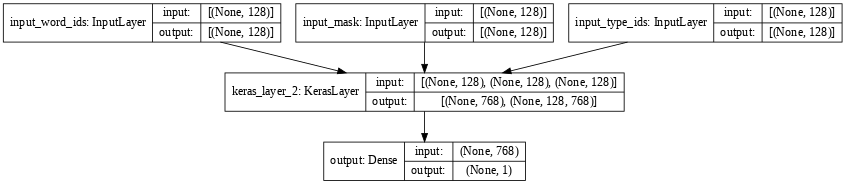

In [ ]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=60, )

## Task 11: Evaluate the BERT Text Classification Model

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
#es1 = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1)

es = ModelCheckpoint("my_keras_model.h5", save_best_only=True)
es1 = EarlyStopping(patience=1, restore_best_weights=True)


In [ ]:
# Train model
epochs = 10
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    verbose=1,callbacks=[es, es1])

Epoch 1/10
779/779 [==============================] - 394s 490ms/step - loss: 0.6288 - binary_accuracy: 0.6399 - val_loss: 0.5754 - val_binary_accuracy: 0.6936
Epoch 2/10
779/779 [==============================] - 382s 489ms/step - loss: 0.5520 - binary_accuracy: 0.7216 - val_loss: 0.5484 - val_binary_accuracy: 0.7223
Epoch 3/10
779/779 [==============================] - 382s 489ms/step - loss: 0.5158 - binary_accuracy: 0.7494 - val_loss: 0.5372 - val_binary_accuracy: 0.7407
Epoch 4/10
779/779 [==============================] - 382s 489ms/step - loss: 0.4883 - binary_accuracy: 0.7690 - val_loss: 0.5378 - val_binary_accuracy: 0.7413


### Plots

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

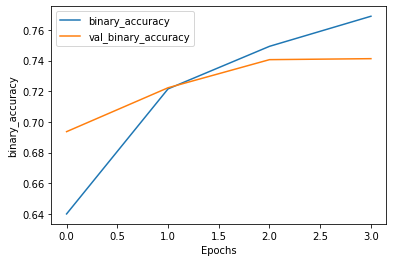

In [ ]:
plot_graphs(history, 'binary_accuracy')

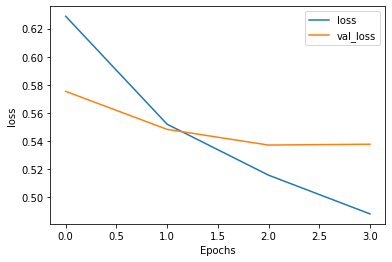

In [ ]:
plot_graphs(history, 'loss')

### Testing

In [ ]:
test_data = tf.data.Dataset.from_tensor_slices((test_df.pair.values, [0]*test_df.shape[0]))
test_data = (test_data.map(to_feature_map).batch(1))

In [ ]:
eval=model.evaluate(test_data, verbose=1)

3118/3118 [==============================] - 34s 11ms/step - loss: 1.0052 - binary_accuracy: 0.5051


In [ ]:
true_label=test_df['label']

In [ ]:
true_label.shape

(3118,)

In [ ]:
test_df.label.sum()

1613

In [ ]:
pred_label = model.predict(test_data)

In [ ]:
pred_label.shape

(3118, 1)

In [ ]:
type(pred_label)

numpy.ndarray

In [ ]:
pred=[1 if pred >=0.50 else 0 for pred in pred_label]

In [ ]:
sum(pred)

1543

In [ ]:
from pandas import DataFrame
pred_df = DataFrame (pred,columns=['pred_label'])

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score
precision_score(true_label,pred_df),recall_score(true_label,pred_df),f1_score(true_label,pred_df)

(0.7621516526247569, 0.7290762554246745, 0.7452471482889733)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(true_label,pred_df)

0.742142398973701

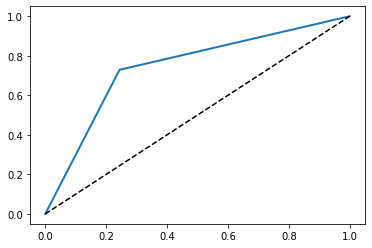

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(true_label, pred_df)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--')

plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(true_label, pred_df)

0.7426112174133338